# **Customer Churn Prediction Challenge For Azubian**

## **Introduction**

---

This projet is based on a Zindi challenge for an African telecommunications company(Expresso) that provides customers with airtime and mobile data bundles. The objective of this project is to develop a machine learning model to predict the likelihood of each customer “churning,” i.e. becoming inactive and not making any transactions for 90 days. This notebook contains the EDA and model development processes. This solution will help this telecom company to better serve their customers by understanding which customers are at risk of leaving.

## **Importing Required Library**

In [67]:
import pandas as pd
import urllib, os, pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import preprocessing 
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import FunctionTransformer, PolynomialFeatures, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn import compose
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
#SMOTE
from imblearn.over_sampling import SMOTE, SMOTENC
# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

# Ignoring warnings
import warnings
warnings.filterwarnings("ignore")
# Setup reproductibility
np.random.seed(0)

In [68]:
# Mounting google drive
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## **Loading/Reading the Dataset**

In [69]:
path = "/content/gdrive/MyDrive/Capstone/Data/"
train = pd.read_csv(path+'Train.csv')
test = pd.read_csv(path+'Test.csv')
submission = pd.read_csv(path+'SampleSubmission.csv')
variable_definition = pd.read_csv(path+'VariableDefinitions.csv')

In [70]:
# Visualising Variable definitions
variable_definition

,Variable Definitions,Unnamed: 1,Unnamed: 2
0,NaN,French,English
1,NaN,Le dataset churn comprend 19 variables dont 15...,The churn dataset includes 19 variables includ...
2,user_id,NaN,NaN
3,REGION,la localité de chaque client,the location of each client
4,TENURE,la durée dans le reseau,duration in the network
5,MONTANT,montant de recharge,top-up amount
6,FREQUENCE_RECH,nombre de fois que le client a fait une recharge,number of times the customer refilled
7,REVENUE,revenu mensuel de chaque client,monthly income of each client
8,ARPU_SEGMENT,revenu sur 90 jours/3,income over 90 days / 3
9,FREQUENCE,nombre de fois que client à fait un revenu,number of times the client has made an income


In [71]:
# Visualising train data
train.head()

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN
0,7ee9e11e342e27c70455960acc80d3f91c1286d1,DAKAR,K > 24 month,20000.0,47.0,21602.0,7201.0,52.0,8835.0,3391.0,396.0,185.0,NaN,NaN,NO,62,On net 200F=Unlimited _call24H,30.0,0
1,50443f42bdc92b10388fc56e520e4421a5fa655c,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,3,NaN,NaN,0
2,da90b5c1a9b204c186079f89969aa01cb03c91b2,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,1,NaN,NaN,0
3,364ec1b424cdc64c25441a444a16930289a0051e,SAINT-LOUIS,K > 24 month,7900.0,19.0,7896.0,2632.0,25.0,9385.0,27.0,46.0,20.0,NaN,2.0,NO,61,"Data:490F=1GB,7d",7.0,0
4,d5a5247005bc6d41d3d99f4ef312ebb5f640f2cb,DAKAR,K > 24 month,12350.0,21.0,12351.0,4117.0,29.0,9360.0,66.0,102.0,34.0,NaN,NaN,NO,56,All-net 500F=2000F;5d,11.0,0


In [72]:
# Visualising test data
test.head()

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK
0,51fe4c3347db1f8571d18ac03f716c41acee30a4,MATAM,I 18-21 month,2500.0,5.0,2500.0,833.0,5.0,0.0,64.0,70.0,NaN,NaN,NaN,NO,35,All-net 500F=2000F;5d,5.0
1,5ad5d67c175bce107cc97b98c4e37dcc38aa7f3e,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,2,NaN,NaN
2,5a4db591c953a8d8f373877fad37aaf4268899a1,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NO,22,NaN,NaN
3,8bf9b4d8880aeba1c9a0da48be78f12e629be37c,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,6,NaN,NaN
4,c7cdf2af01e9fa95bf498b68c122aa4b9a8d10df,SAINT-LOUIS,K > 24 month,5100.0,7.0,5637.0,1879.0,15.0,7783.0,30.0,24.0,0.0,0.0,NaN,NO,60,"Data:1000F=2GB,30d",4.0


## **Exploring the Dataset**

In [73]:
# Checking the shape of the data(number of rolls and columns)
(train.shape), (test.shape)

((1077024, 19), (190063, 18))

In [74]:
# Checking the completness of the data, and data types of each column
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1077024 entries, 0 to 1077023
Data columns (total 19 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   user_id         1077024 non-null  object 
 1   REGION          652687 non-null   object 
 2   TENURE          1077024 non-null  object 
 3   MONTANT         699139 non-null   float64
 4   FREQUENCE_RECH  699139 non-null   float64
 5   REVENUE         714669 non-null   float64
 6   ARPU_SEGMENT    714669 non-null   float64
 7   FREQUENCE       714669 non-null   float64
 8   DATA_VOLUME     547261 non-null   float64
 9   ON_NET          683850 non-null   float64
 10  ORANGE          629880 non-null   float64
 11  TIGO            432250 non-null   float64
 12  ZONE1           84898 non-null    float64
 13  ZONE2           68794 non-null    float64
 14  MRG             1077024 non-null  object 
 15  REGULARITY      1077024 non-null  int64  
 16  TOP_PACK        626129 non-null   ob

In [75]:
# Identifying target column(s)
target_cols = list(set(train.columns) - set(test.columns))
target_col = target_cols[-1]

target_cols, target_col

(['CHURN'], 'CHURN')

## **Data Types**

The train data consist of 1077024 rows and 19 columns, whiles the test data consist of 190063 rows and 18 columns. Each row represents the data of a unique customer. The difference between the train and test dataset is a column called CHURN that indicates if a client churned or did not churn. This is the target variable. There are 4 categorical variables(excluding the User Id column), and 13 Numerical variables.

#### **Target:** 
- CHURN (binary)

#### **Categorical Features:**
- REGION
- TENURE
- MRG
- TOP_PACK

#### **Numerical Features:**
- MONTANT
- FREQUENCE_RECH
- REVENUE
- ARPU_SEGMENT
- FREQUENCE
- DATA_VOLUME
- ON_NET
- ORANGE
- TIGO
- ZONE1
- ZONE2
- REGULARITY
- FREQ_TOP_PACK



## **Data Evaluation**

### **1 General EDA**

In [76]:
def data_distribution_plot(df):
    sns.set_context('notebook', font_scale = 2)
    sns.set(style = 'darkgrid')
    fig = plt.figure(figsize = (15, 5))
    plt.subplot(121)
    plt.pie(df.CHURN.value_counts(),labels = ['No Churn', 'Churn'], autopct = '%.1f%%', radius = 1, textprops={
        'fontsize': 18, 'fontweight': 'bold'})
    plt.title('Churn Outcome Pie Chart', fontsize = 26, fontweight = 'bold')
    plt.subplot(122)
    graph = sns.countplot(df.CHURN)
    graph.set_xlabel('Churn (0: No, 1: Yes)', fontweight = 'bold', fontsize = 18)
    graph.set_ylabel('Count', fontweight = 'bold', fontsize = 18)
    plt.title('Churn Outcome Distribution', fontsize = 26, fontweight = 'bold')
    plt.tight_layout()

### 1.1 What is the percentage of Churned Customers?

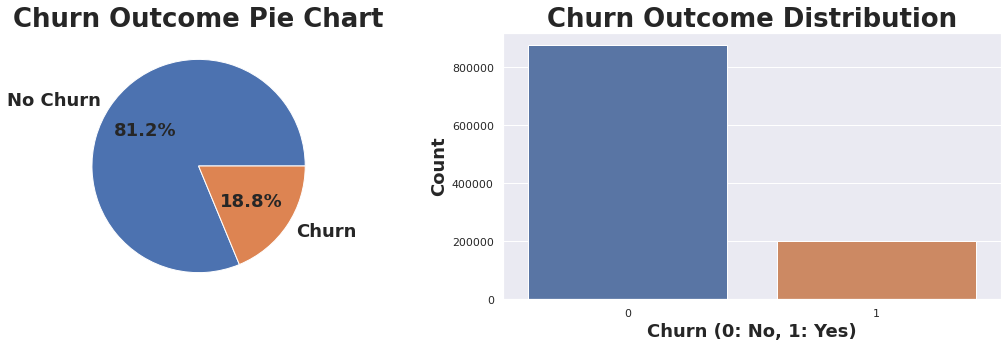

In [77]:
data_distribution_plot(train)

**Comments:** 
- The percentage of Churned Customers are about 18.8%

### **2 Categorical Features EDA**

In this section, we will visualise each categorical variable in the data separately by visualising the:
- Percentage Composition of the unique values in each variable
- Distribution of the unique values in each variable by CHURN
- Violin plot for REVENUE by 'variable'

In [78]:
# Functions for Categorical Features EDA

def region_dist_plots(df):
    sns.set(style = 'whitegrid')
    sns.set_context('paper', font_scale = 2)
    fig = plt.figure(figsize = (32,10))
    
    plt.subplot(131)
    plt.pie(df.REGION.value_counts(),labels = ['DAKAR', 'THIES', 'SAINT-LOUIS', 'LOUGA', 'KAOLACK',
                                               'DIOURBEL', 'TAMBACOUNDA','KAFFRINE','KOLDA','FATICK','MATAM',
                                               'ZIGUINCHOR','SEDHIOU', 'KEDOUGOU'], autopct = '%.1f%%', radius = 1, 
                                               textprops = {'fontsize':16, 'fontweight':'light'} )
    plt.title('Customer REGION Composition', fontweight = 'bold', fontsize = 30)
  

    plt.subplot(132)
    a = sns.countplot(data = df, x = 'REGION', hue = 'CHURN', )
    a.set_title('Region Distribution by Churn', fontsize = 30, fontweight = 'bold')
    a.set_xlabel('Region', fontweight = 'bold', fontsize = 22)
    a.set_ylabel('% of Customers', fontweight = 'bold', fontsize = 22)
    a.set_xticklabels(a.get_xticklabels(), rotation = 70, fontweight = 'bold', fontsize = 16)

    plt.subplot(133)
    x = sns.violinplot('REGION', 'REVENUE', 'CHURN', df, split = True)
    x.set_title('Violin Plot for Monthly Revenue by Region', fontsize = 30, fontweight = 'bold')
    x.set_xlabel('REGION', fontsize = 22, fontweight = 'bold')
    x.set_xticklabels(x.get_xticklabels(), rotation = 70, fontweight = 'bold', fontsize = 16)
    plt.tight_layout()

def tenure_dist_plots(df):
    sns.set(style = 'whitegrid')
    sns.set_context('paper', font_scale = 2)
    fig = plt.figure(figsize = (32,10))
    
    plt.subplot(131)
    plt.pie(df.TENURE.value_counts(),labels = ['K', 'I', 'H', 'G', 'J', 'F','E','D'],
                                              autopct = '%.1f%%', radius = 1, 
                                              textprops = {'fontsize':16, 'fontweight':'light'} )
    plt.title('Tenure Composition of Customers', fontweight = 'bold', fontsize = 30)
   

    plt.subplot(132)
    a = sns.countplot(data = df, x = 'TENURE', hue = 'CHURN', )
    a.set_title('Tenure Distribution by Churn', fontsize = 30, fontweight = 'bold')
    a.set_xlabel('Tenure', fontweight = 'bold', fontsize = 22)
    a.set_ylabel('% of Customers', fontweight = 'bold', fontsize = 22)
    a.set_xticklabels(a.get_xticklabels(), rotation = 70, fontweight = 'bold', fontsize = 16)

    plt.subplot(133)
    x = sns.violinplot('TENURE', 'REVENUE', 'CHURN', df, split = True)
    x.set_title('Violin Plot for Monthly Revenue by Tenure', fontsize = 30, fontweight = 'bold')
    x.set_xlabel('TENURE', fontsize = 22, fontweight = 'bold')
    x.set_xticklabels(x.get_xticklabels(), rotation = 70, fontweight = 'bold', fontsize = 16)
    plt.tight_layout()

def top_pack_dist_plots(df):
    sns.set(style = 'whitegrid')
    sns.set_context('paper', font_scale = 2)
    fig = plt.figure(figsize = (32,10))
    
    plt.subplot(131)
    plt.pie(df.TOP_PACK.value_counts().head(5),labels = ['All-net 500F=2000F;5d', 'On net 200F=Unlimited _call24H', 'Data:490F=1GB,7d',
                                                        'Data: 100 F=40MB,24H', 'Mixt 250F=Unlimited_call24H'],autopct = '%.1f%%', 
                                                        radius = 1, textprops = {'fontsize':16, 'fontweight':'light'} )
    plt.title('Composition of Customers on Packages(Top 5)', fontweight = 'bold', fontsize = 24)
    plt.subplot(132)

    a = sns.countplot(data = df, x = 'TOP_PACK', hue = 'CHURN', order = ['All-net 500F=2000F;5d', 'On net 200F=Unlimited _call24H','Data:490F=1GB,7d',
                                                                         'Data: 100 F=40MB,24H', 'Mixt 250F=Unlimited_call24H'])
    a.set_title('Top 5 Packages Distribution by Churn', fontsize = 24, fontweight = 'bold')
    a.set_xlabel('Top 5 Packages', fontweight = 'bold', fontsize = 22)
    a.set_ylabel('% of Customers', fontweight = 'bold', fontsize = 22)
    a.set_xticklabels(a.get_xticklabels(), rotation = 70, fontweight = 'bold', fontsize = 16)
    plt.subplot(133)

    x = sns.violinplot('TOP_PACK', 'REVENUE', 'CHURN', df, order = ['All-net 500F=2000F;5d', 'On net 200F=Unlimited _call24H', 'Data:490F=1GB,7d',
                                                        'Data: 100 F=40MB,24H', 'Mixt 250F=Unlimited_call24H'], split = True)
    x.set_title('Violin Plot for Monthly Revenue by Top 5 Packages', fontsize = 24, fontweight = 'bold')
    x.set_xlabel('Top 5 Packages', fontsize = 22, fontweight = 'bold')
    x.set_xticklabels(x.get_xticklabels(), rotation = 70, fontweight = 'bold', fontsize = 16)
    plt.tight_layout()


def mrg_dist_plots(df):
    sns.set(style = 'whitegrid')
    sns.set_context('paper', font_scale = 2)
    fig = plt.figure(figsize = (15,5))
    
    plt.pie(df.MRG.value_counts(), autopct = '%.1f%%', radius = 1, 
    textprops = {'fontsize':14, 'fontweight':'light'} )
    plt.title('MRG Composition of Customers', fontweight = 'bold', fontsize = 22)
   
    plt.tight_layout()


### 2.1 REGION

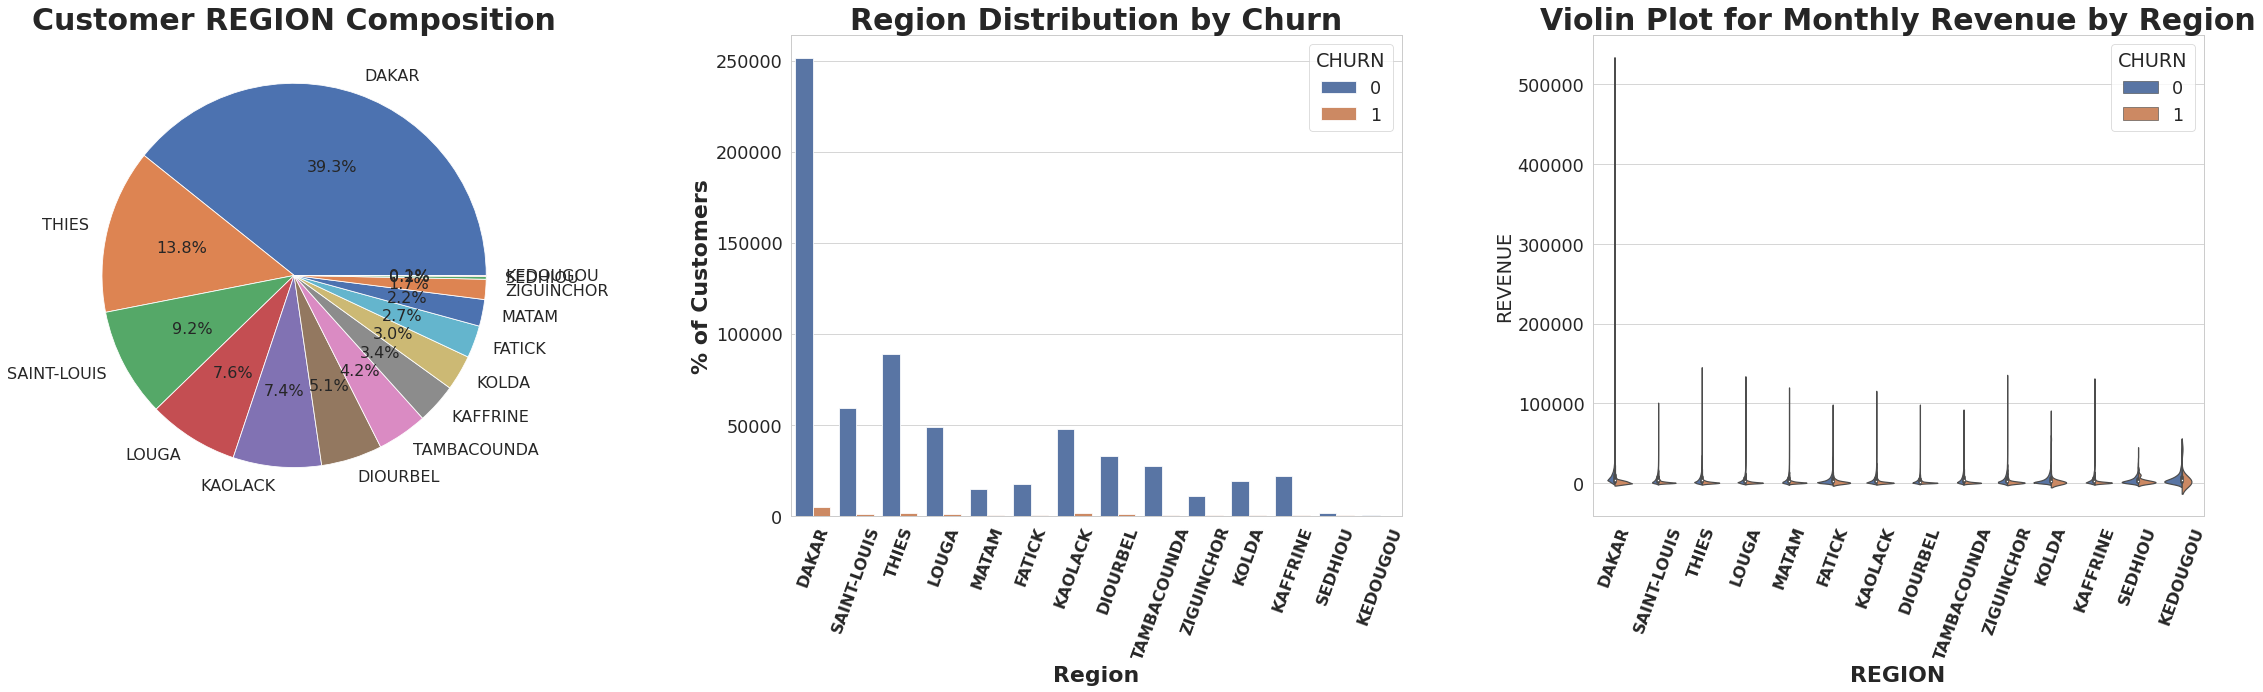

In [79]:
region_dist_plots(train)

**Comments:** 
- Majority of customers are located in the Dakar region (About 39.3%)
- Dakar region has the majority of churn customers

### 2.2 TENURE

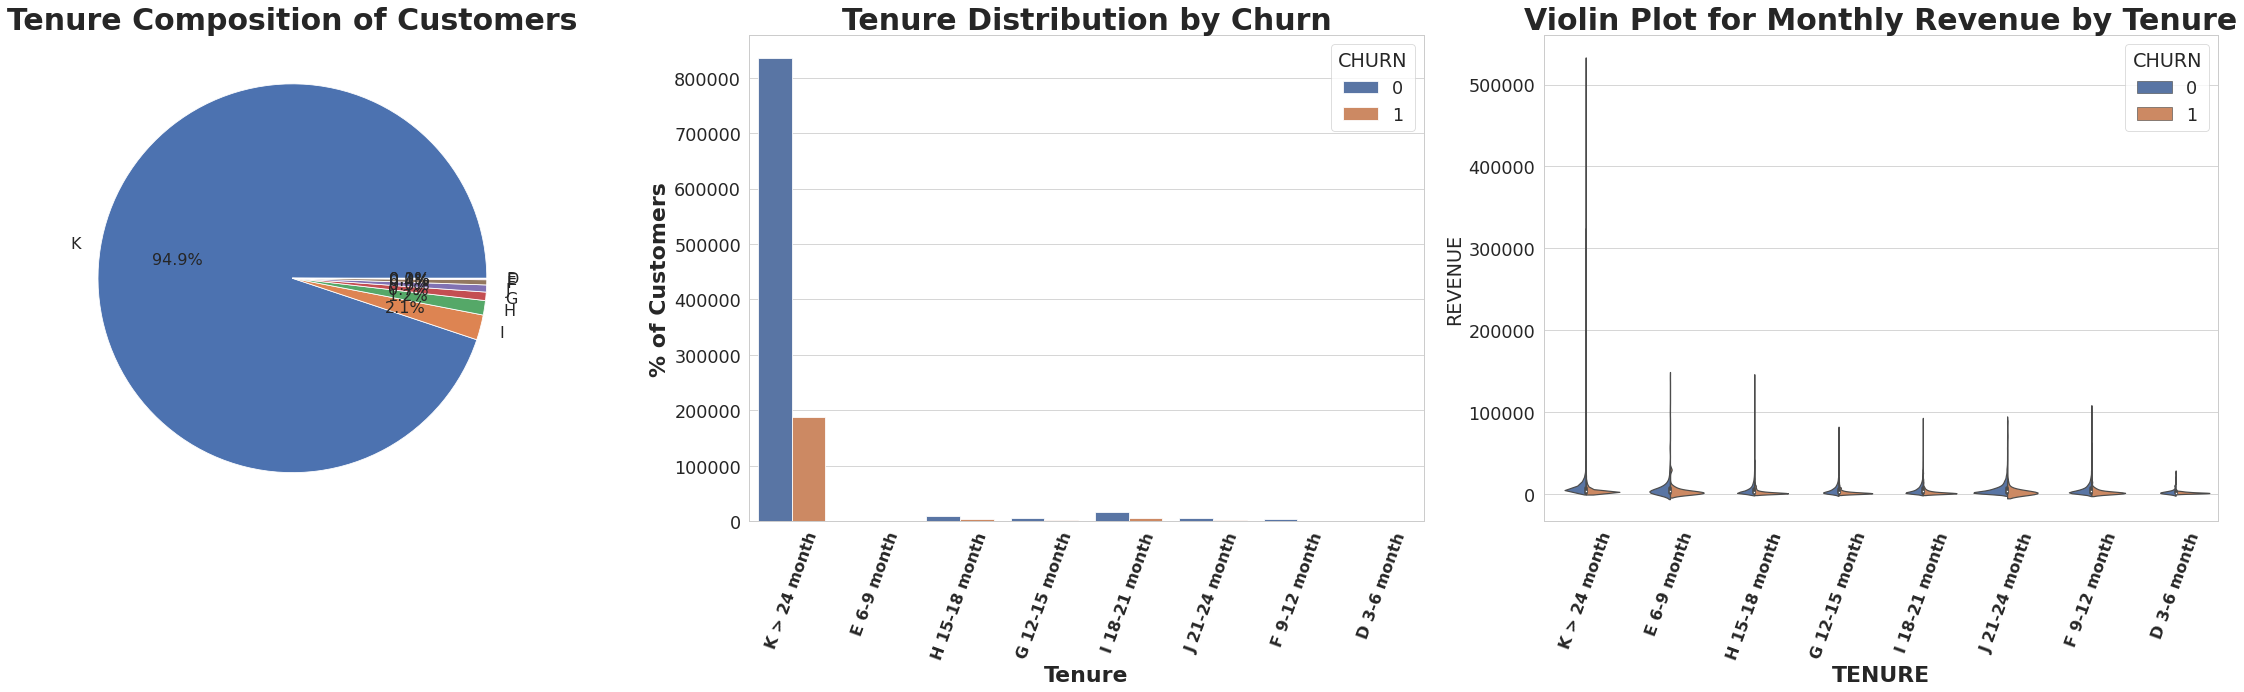

In [80]:
tenure_dist_plots(train)

**Comments:** 
- Over 90% of customers have been with the company for more than 2 years
- More customers tend to churn after staying with company for more than 24 months

### 2.3 TOP PACK (The most active packs)

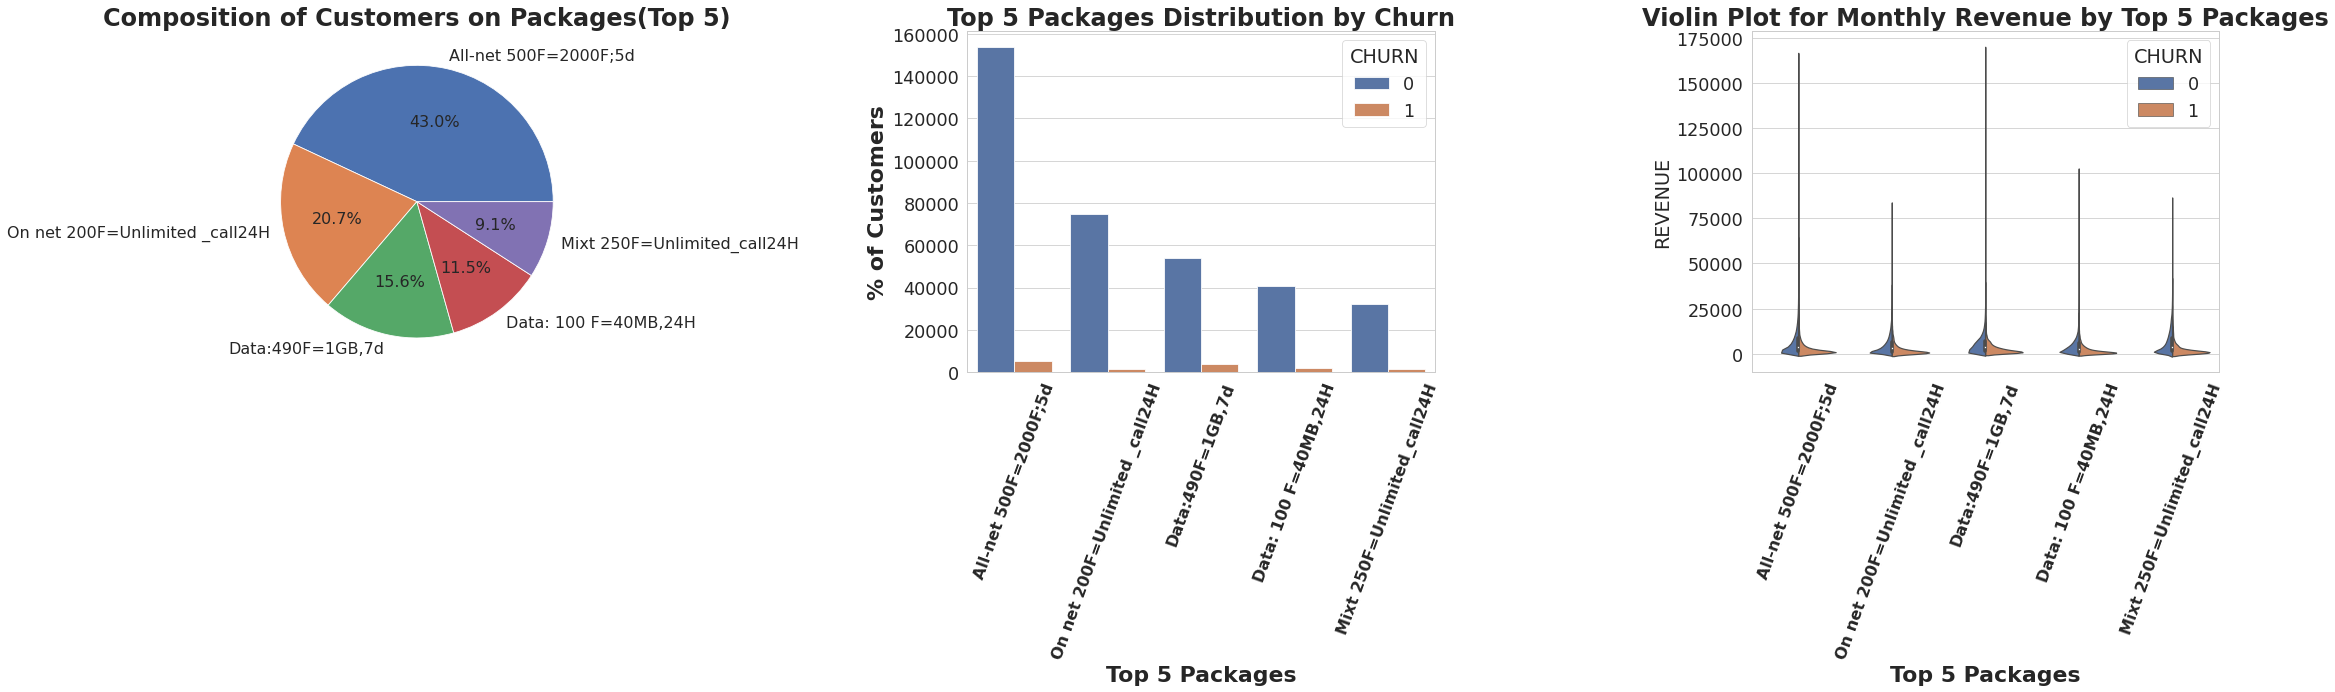

In [81]:
top_pack_dist_plots(train)

**Comments:** 
- All-net 500F=2000F;5d is the top package that most customers subscribe to.
- Overall, more customers on **All-net 500F=2000F;5d** Churn than others on top 5 packages, but a higher proportion of cusstomers on **Data:490F=1GB,7d** Churn than others on top 5 packages.

### 2.4 MRG(a client who is going)

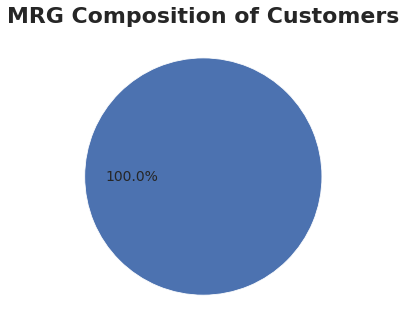

In [82]:
mrg_dist_plots(train)

### **3 Numerical Feature EDA**

In [83]:
# Functions for Numerical Features EDA

def kde_plot(df, feature1, feature2, feature3, feature4, feature5, feature6, feature7, feature8, feature9, feature10, feature11, feature12, feature13):
    sns.set(style = 'whitegrid')
    sns.set_context('paper', font_scale = 2)
    fig = plt.figure(figsize = (30,30))

    plt.subplot(531)
    plt.title(f"Kernel Density Estimation for {feature1}", fontsize = 22, fontweight = 'bold')
    ax = sns.kdeplot(df[df.CHURN == 0][feature1].dropna(), label = 'No Churn', lw = 2, legend = True)
    #plt.legend = True
    ax1 = sns.kdeplot(df[df.CHURN == 1][feature1].dropna(), label = 'Churn', lw = 2, legend = True)
    plt.xlabel(feature1, fontsize = 20, fontweight = 'bold')
    plt.legend(fontsize = 15, loc = 'upper right', edgecolor = 'black')
    plt.tight_layout()

    plt.subplot(532)
    plt.title(f"Kernel Density Estimation for {feature2}", fontsize = 22, fontweight = 'bold')
    bx = sns.kdeplot(df[df.CHURN == 0][feature2].dropna(), label = 'No Churn', lw = 2, legend = True)
    bx1 = sns.kdeplot(df[df.CHURN == 1][feature2].dropna(), label = 'Churn', lw = 2, legend = True)
    plt.xlabel(feature2, fontsize = 20, fontweight = 'bold')
    plt.legend(fontsize = 15, loc = 'upper right', edgecolor = 'black')
    plt.tight_layout()

    plt.subplot(533)
    plt.title(f"Kernel Density Estimation for {feature3}", fontsize = 22, fontweight = 'bold')
    cx = sns.kdeplot(df[df.CHURN == 0][feature3].dropna(), label = 'No Churn', lw = 2, legend = True)
    #plt.legend = True
    cx1 = sns.kdeplot(df[df.CHURN == 1][feature3].dropna(), label = 'Churn', lw = 2, legend = True)
    plt.xlabel(feature3, fontsize = 20, fontweight = 'bold')
    plt.legend(fontsize = 15, loc = 'upper right', edgecolor = 'black')
    plt.tight_layout()

    plt.subplot(534)
    plt.title(f"Kernel Density Estimation for {feature4}", fontsize = 22, fontweight = 'bold')
    dx = sns.kdeplot(df[df.CHURN == 0][feature4].dropna(), label = 'No Churn', lw = 2, legend = True)
    #plt.legend = True
    dx1 = sns.kdeplot(df[df.CHURN == 1][feature4].dropna(), label = 'Churn', lw = 2, legend = True)
    plt.xlabel(feature4, fontsize = 20, fontweight = 'bold')
    plt.legend(fontsize = 15, loc = 'upper right', edgecolor = 'black')
    plt.tight_layout()

    plt.subplot(535)
    plt.title(f"Kernel Density Estimation for {feature5}", fontsize = 22, fontweight = 'bold')
    ex = sns.kdeplot(df[df.CHURN == 0][feature5].dropna(), label = 'No Churn', lw = 2, legend = True)
    #plt.legend = True
    ex1 = sns.kdeplot(df[df.CHURN == 1][feature5].dropna(), label = 'Churn', lw = 2, legend = True)
    plt.xlabel(feature5, fontsize = 20, fontweight = 'bold')
    plt.legend(fontsize = 15, loc = 'upper right', edgecolor = 'black')
    plt.tight_layout()

    plt.subplot(536)
    plt.title(f"Kernel Density Estimation for {feature6}", fontsize = 22, fontweight = 'bold')
    fx = sns.kdeplot(df[df.CHURN == 0][feature6].dropna(), label = 'No Churn', lw = 2, legend = True)
    #plt.legend = True
    fx1 = sns.kdeplot(df[df.CHURN == 1][feature6].dropna(), label = 'Churn', lw = 2, legend = True)
    plt.xlabel(feature6, fontsize = 20, fontweight = 'bold')
    plt.legend(fontsize = 15, loc = 'upper right', edgecolor = 'black')
    plt.tight_layout()

    plt.subplot(537)
    plt.title(f"Kernel Density Estimation for {feature7}", fontsize = 22, fontweight = 'bold')
    fx = sns.kdeplot(df[df.CHURN == 0][feature7].dropna(), label = 'No Churn', lw = 2, legend = True)
    #plt.legend = True
    fx1 = sns.kdeplot(df[df.CHURN == 1][feature7].dropna(), label = 'Churn', lw = 2, legend = True)
    plt.xlabel(feature7, fontsize = 20, fontweight = 'bold')
    plt.legend(fontsize = 15, loc = 'upper right', edgecolor = 'black')
    plt.tight_layout()

    plt.subplot(538)
    plt.title(f"Kernel Density Estimation for {feature8}", fontsize = 22, fontweight = 'bold')
    fx = sns.kdeplot(df[df.CHURN == 0][feature8].dropna(), label = 'No Churn', lw = 2, legend = True)
    #plt.legend = True
    fx1 = sns.kdeplot(df[df.CHURN == 1][feature8].dropna(), label = 'Churn', lw = 2, legend = True)
    plt.xlabel(feature8, fontsize = 20, fontweight = 'bold')
    plt.legend(fontsize = 15, loc = 'upper right', edgecolor = 'black')
    plt.tight_layout()

    plt.subplot(539)
    plt.title(f"Kernel Density Estimation for {feature9}", fontsize = 22, fontweight = 'bold')
    fx = sns.kdeplot(df[df.CHURN == 0][feature9].dropna(), label = 'No Churn', lw = 2, legend = True)
    #plt.legend = True
    fx1 = sns.kdeplot(df[df.CHURN == 1][feature9].dropna(), label = 'Churn', lw = 2, legend = True)
    plt.xlabel(feature9, fontsize = 20, fontweight = 'bold')
    plt.legend(fontsize = 15, loc = 'upper right', edgecolor = 'black')
    plt.tight_layout()

    plt.subplot(5,3,10)
    plt.title(f"Kernel Density Estimation for {feature10}", fontsize = 22, fontweight = 'bold')
    fx = sns.kdeplot(df[df.CHURN == 0][feature10].dropna(), label = 'No Churn', lw = 2, legend = True)
    #plt.legend = True
    fx1 = sns.kdeplot(df[df.CHURN == 1][feature10].dropna(), label = 'Churn', lw = 2, legend = True)
    plt.xlabel(feature10, fontsize = 20, fontweight = 'bold')
    plt.legend(fontsize = 15, loc = 'upper right', edgecolor = 'black')
    plt.tight_layout()

    plt.subplot(5,3,11)
    plt.title(f"Kernel Density Estimation for {feature11}", fontsize = 22, fontweight = 'bold')
    fx = sns.kdeplot(df[df.CHURN == 0][feature11].dropna(), label = 'No Churn', lw = 2, legend = True)
    #plt.legend = True
    fx1 = sns.kdeplot(df[df.CHURN == 1][feature11].dropna(), label = 'Churn', lw = 2, legend = True)
    plt.xlabel(feature11, fontsize = 20, fontweight = 'bold')
    plt.legend(fontsize = 15, loc = 'upper right', edgecolor = 'black')
    plt.tight_layout()

    plt.subplot(5,3,12)
    plt.title(f"Kernel Density Estimation for {feature12}", fontsize = 22, fontweight = 'bold')
    fx = sns.kdeplot(df[df.CHURN == 0][feature12].dropna(), label = 'No Churn', lw = 2, legend = True)
    #plt.legend = True
    fx1 = sns.kdeplot(df[df.CHURN == 1][feature12].dropna(), label = 'Churn', lw = 2, legend = True)
    plt.xlabel(feature12, fontsize = 20, fontweight = 'bold')
    plt.legend(fontsize = 15, loc = 'upper right', edgecolor = 'black')
    plt.tight_layout()

    plt.subplot(5,3,13)
    plt.title(f"Kernel Density Estimation for {feature13}", fontsize = 22, fontweight = 'bold')
    fx = sns.kdeplot(df[df.CHURN == 0][feature13].dropna(), label = 'No Churn', lw = 2, legend = True)
    #plt.legend = True
    fx1 = sns.kdeplot(df[df.CHURN == 1][feature13].dropna(), label = 'Churn', lw = 2, legend = True)
    plt.xlabel(feature13, fontsize = 20, fontweight = 'bold')
    plt.legend(fontsize = 15, loc = 'upper right', edgecolor = 'black')
    plt.tight_layout()


### 3.1 Summary of numerical fields

In [84]:
train.select_dtypes(include=['int64', 'float64']).describe().T

,count,mean,std,min,25%,50%,75%,max
MONTANT,699139.0,5529.210895,7104.737952,20.0,1000.0,3000.0,7350.0,470000.0
FREQUENCE_RECH,699139.0,11.523756,13.261938,1.0,2.0,7.0,16.0,131.0
REVENUE,714669.0,5506.050798,7175.625010,1.0,1000.0,3000.0,7360.0,532177.0
ARPU_SEGMENT,714669.0,1835.355961,2391.870902,0.0,333.0,1000.0,2453.0,177392.0
FREQUENCE,714669.0,13.974439,14.687059,1.0,3.0,9.0,20.0,91.0
DATA_VOLUME,547261.0,3368.801722,12898.928039,0.0,0.0,258.0,2905.0,1702309.0
ON_NET,683850.0,277.065798,874.315378,0.0,5.0,27.0,156.0,50809.0
ORANGE,629880.0,95.160804,203.020261,0.0,7.0,29.0,99.0,12040.0
TIGO,432250.0,23.105018,64.035464,0.0,2.0,6.0,20.0,4174.0
ZONE1,84898.0,8.167483,39.245883,0.0,0.0,1.0,3.0,2507.0


### 3.2 KDE Plots for Numerical Features

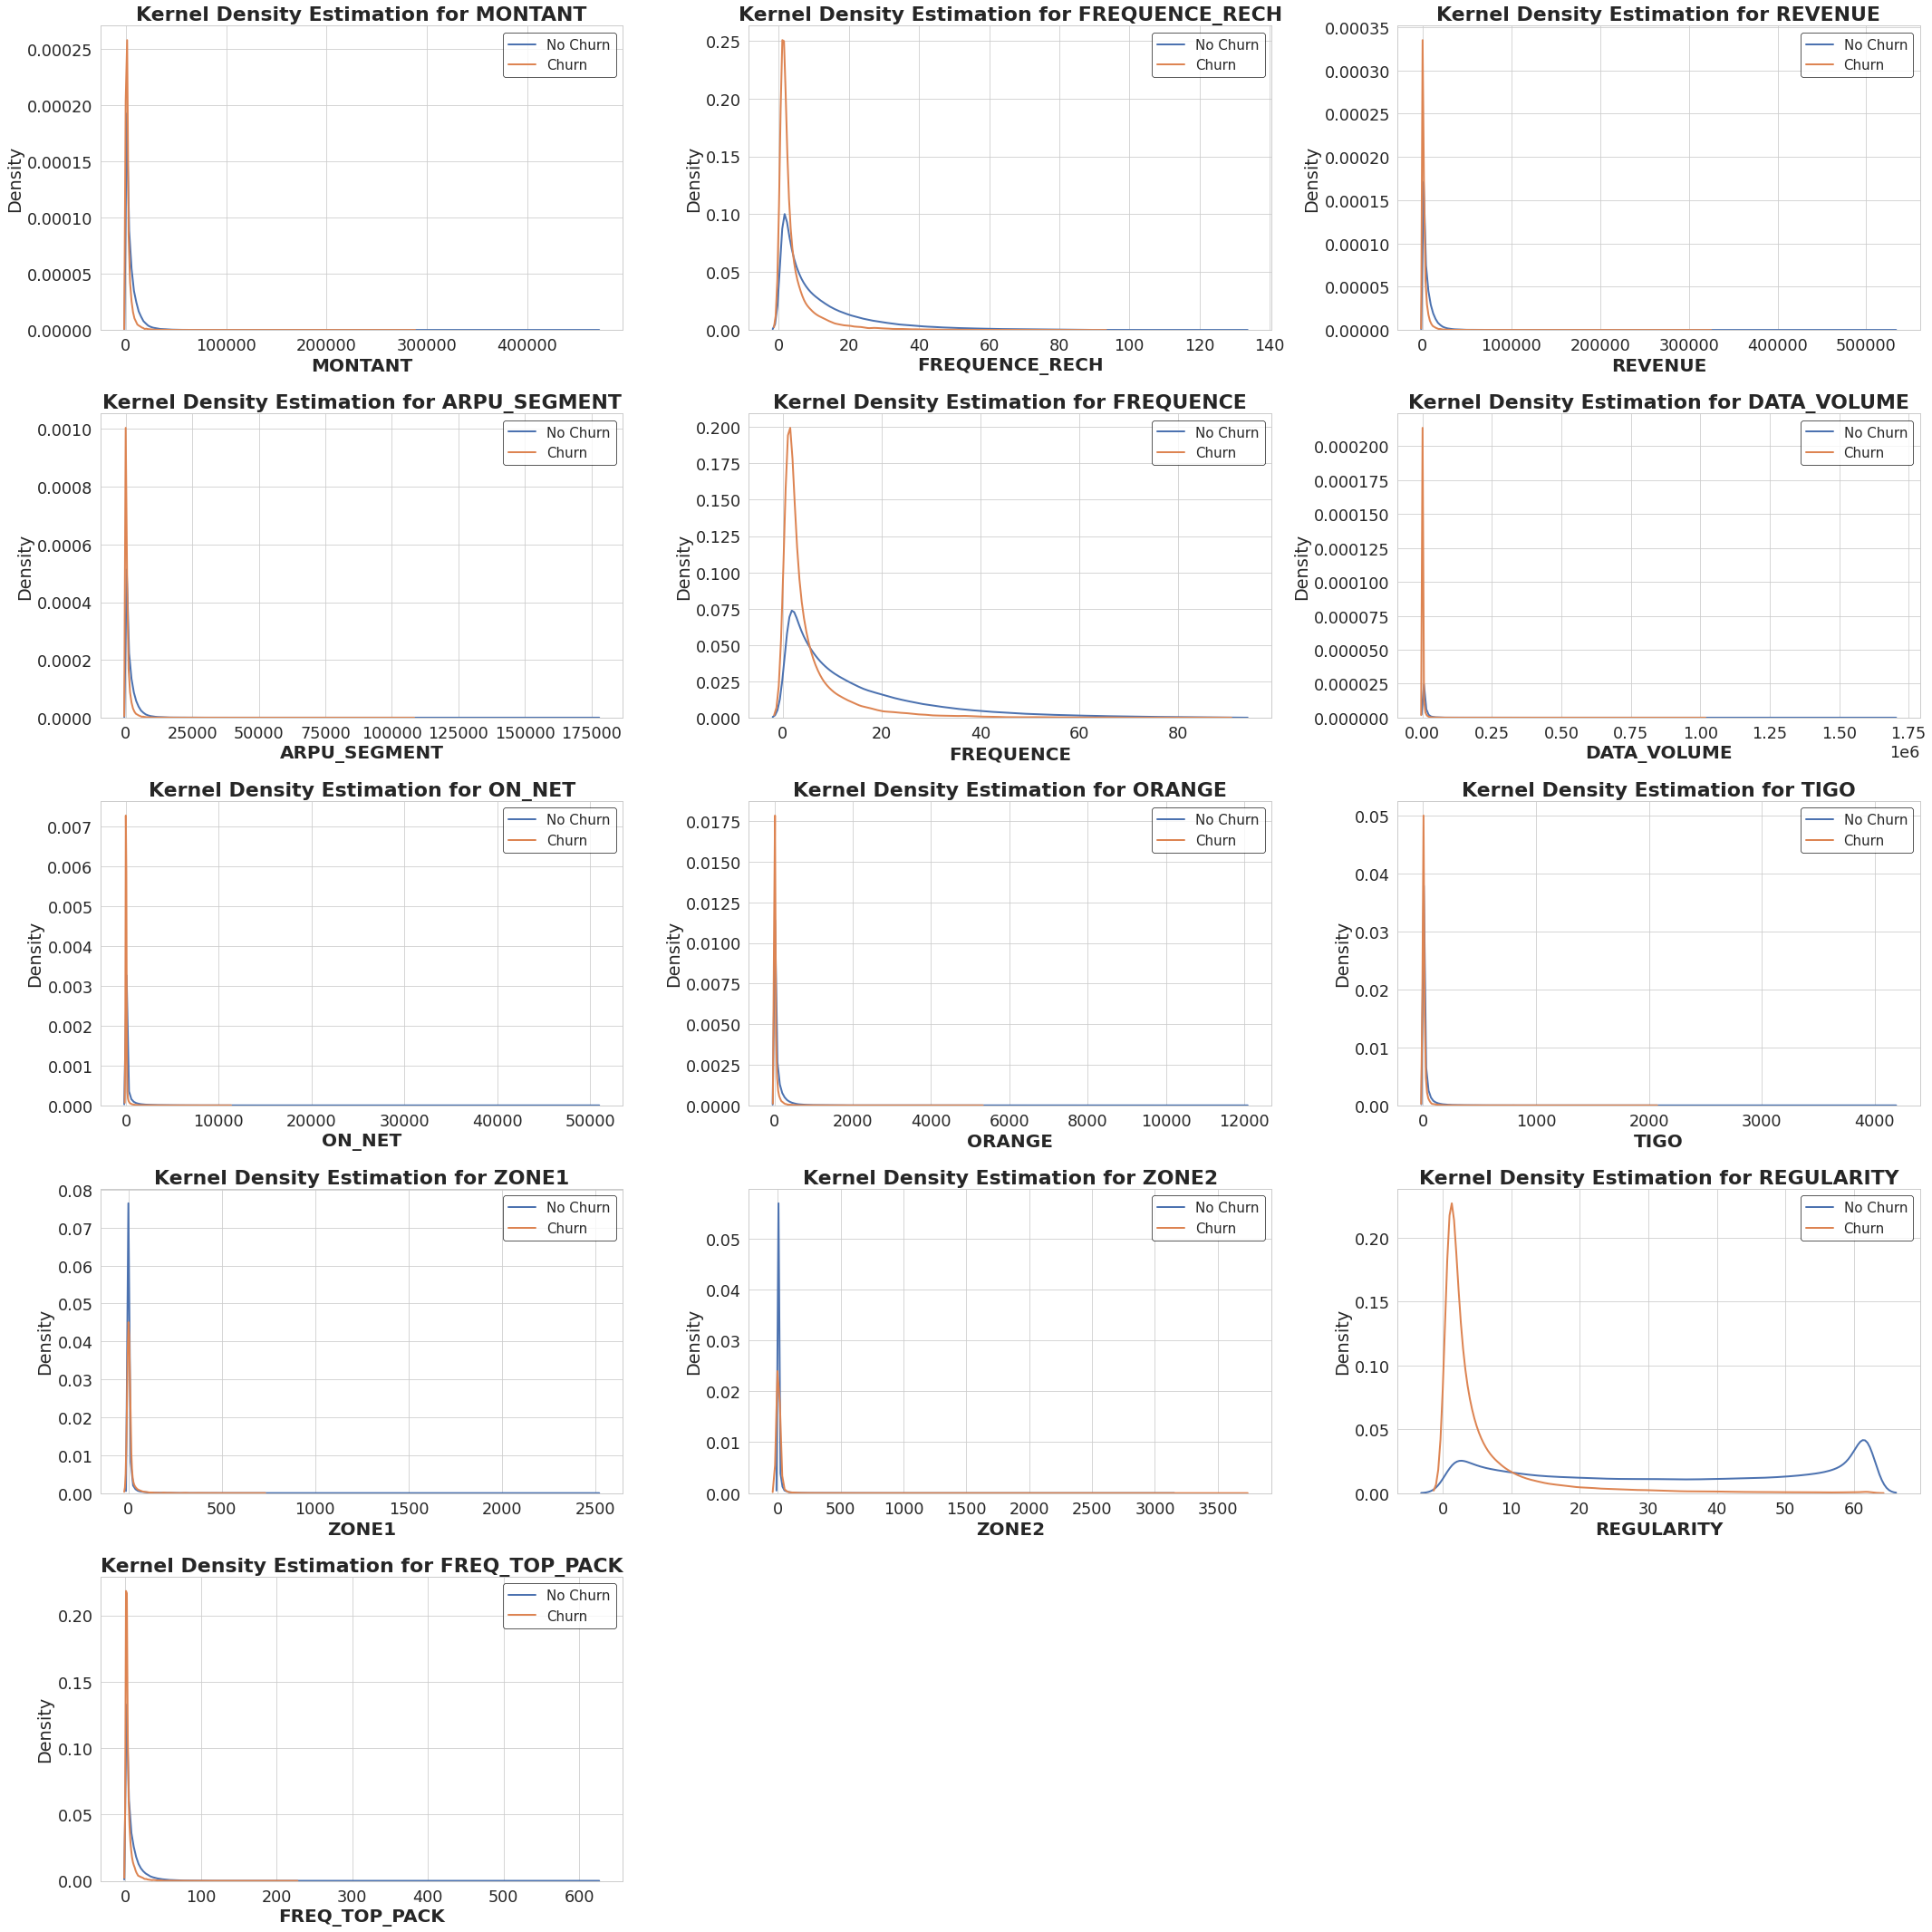

In [85]:
kde_plot(train, 'MONTANT', 'FREQUENCE_RECH', 'REVENUE', 'ARPU_SEGMENT', 'FREQUENCE', 'DATA_VOLUME', 'ON_NET', 'ORANGE', 'TIGO', 'ZONE1', 'ZONE2', 'REGULARITY', 'FREQ_TOP_PACK')

## **Feature Engineering (Selecting the most Interesting Features)**

In [86]:
# for percent [0; 100] of nan in dataframe

features = test.columns
missing_threshold = 50
check = (train[features].isna().sum() / ((train.shape[0]) / 100))

valid_features = check[check < missing_threshold].index.to_list()
check.sort_values(ascending=False)

ZONE2             93.612584
ZONE1             92.117353
TIGO              59.866261
DATA_VOLUME       49.187669
FREQ_TOP_PACK     41.864898
TOP_PACK          41.864898
ORANGE            41.516624
REGION            39.399029
ON_NET            36.505593
FREQUENCE_RECH    35.086033
MONTANT           35.086033
FREQUENCE         33.644097
ARPU_SEGMENT      33.644097
REVENUE           33.644097
MRG                0.000000
REGULARITY         0.000000
TENURE             0.000000
user_id            0.000000
dtype: float64

**Now we will drop all columns with over 50% missing data because this large amount of missing data may have an effect on our model even if we find a way to replace them.**

In [87]:
train[valid_features].infer_objects().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1077024 entries, 0 to 1077023
Data columns (total 15 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   user_id         1077024 non-null  object 
 1   REGION          652687 non-null   object 
 2   TENURE          1077024 non-null  object 
 3   MONTANT         699139 non-null   float64
 4   FREQUENCE_RECH  699139 non-null   float64
 5   REVENUE         714669 non-null   float64
 6   ARPU_SEGMENT    714669 non-null   float64
 7   FREQUENCE       714669 non-null   float64
 8   DATA_VOLUME     547261 non-null   float64
 9   ON_NET          683850 non-null   float64
 10  ORANGE          629880 non-null   float64
 11  MRG             1077024 non-null  object 
 12  REGULARITY      1077024 non-null  int64  
 13  TOP_PACK        626129 non-null   object 
 14  FREQ_TOP_PACK   626129 non-null   float64
dtypes: float64(9), int64(1), object(5)
memory usage: 123.3+ MB


**In addition to the columns dropped based on the percentage of missing data, there are also some irrelevant columns that we need to drop.**
1. we will drop user_id because it will not have any useful effect in training our model.
2. we will also drop MRG since it contains just one unique value among all customers.
3. We will also drop TOP_PACK since it has about 126 unique values which is difficult to group into smaller groups. using onehot encoder to group this variable will introduce so many columns to our data which may affect the accuracy of the model. Also, there is the FREQ_TOP_PACK column to compensate for that.
4. There is no possibility to find the exact REGIONS of the customers with missing REGION data and replacing them with the most common region will lead to misrepresentation and affect the performance of our model

In [88]:
useless_features = ["user_id", "MRG", "TOP_PACK", "REGION"]
useful_features = list(set(valid_features) - set(useless_features))
print(f"[Info] '{len(useful_features)}' feature(s) to use for the next steps. ")

[Info] '11' feature(s) to use for the next steps. 


In [89]:
num_cols = train[useful_features].select_dtypes(include=np.number).columns.tolist()
cat_cols = train[useful_features].select_dtypes(exclude=np.number).columns.tolist()

print( f"Numeric features : {len(num_cols)}" )
print( f"Categorical features : {len(cat_cols)}" )

Numeric features : 10
Categorical features : 1


### **Splitting Train dataset**

In [90]:
X = train[useful_features]
y = train[target_col]

X_test_ = test[useful_features]

X_train_, X_eval_, y_train, y_eval = train_test_split(X, y, test_size=0.2, random_state=0)
(X_train_.shape, y_train.shape) , (X_eval_.shape, y_eval.shape), (X_test_.shape)

(((861619, 11), (861619,)), ((215405, 11), (215405,)), (190063, 11))

In [91]:
X_train_

,MONTANT,ARPU_SEGMENT,REVENUE,FREQUENCE,REGULARITY,ON_NET,ORANGE,TENURE,DATA_VOLUME,FREQUENCE_RECH,FREQ_TOP_PACK
77536,500.0,100.0,301.0,3.0,24,4.0,5.0,K > 24 month,NaN,1.0,NaN
931385,NaN,NaN,NaN,NaN,9,0.0,NaN,K > 24 month,0.0,NaN,NaN
408102,500.0,167.0,500.0,1.0,7,2.0,14.0,K > 24 month,NaN,1.0,1.0
49644,NaN,1.0,4.0,1.0,7,0.0,NaN,K > 24 month,NaN,NaN,NaN
582491,NaN,NaN,NaN,NaN,3,3.0,NaN,K > 24 month,11.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
359783,2000.0,661.0,1983.0,5.0,31,21.0,39.0,K > 24 month,3.0,4.0,2.0
152315,6000.0,1973.0,5920.0,16.0,50,NaN,NaN,K > 24 month,9927.0,16.0,13.0
963395,NaN,NaN,NaN,NaN,2,NaN,NaN,K > 24 month,NaN,NaN,NaN
117952,NaN,NaN,NaN,NaN,3,NaN,NaN,K > 24 month,NaN,NaN,NaN


## **Normalization and Encoding the dataset**

In [92]:
# Pipeline for the Numeric features 
num_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="mean")),
           ("scaler", StandardScaler())]
)

# Pipeline for the Categorical features
encoder_categories = [ train[cat_cols[i] ].append( test[cat_cols[i] ] ).dropna().unique() for i in range(len(cat_cols)) ]

cat_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent")),
           ("encoder", preprocessing.OneHotEncoder(categories=encoder_categories, drop="first", sparse=False)) #if_binary
           ])

# Associate the two pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, selector(dtype_include="number")),
        ("cat", cat_transformer, selector(dtype_exclude="number")),
        # ("num", num_transformer, num_cols),
        # ("cat", cat_transformer, cat_cols),
    ]
)
X_train__, X_eval__, X_test__ = preprocessor.fit_transform(X_train_), preprocessor.transform(X_eval_), preprocessor.transform(X_test_)

# New categorical feature names
feature_names_out = preprocessor.named_transformers_['cat'][-1].get_feature_names_out().tolist()
indexes = [ int(feature_names_out[i][1:feature_names_out[i].find("_")]) for i in range(len(feature_names_out))]
cat_cols_encoded = [  col.replace( f"x{i}", cat_cols[i] )  for col,i in zip(feature_names_out, indexes)]
print( f"Categorical features after encoding : {len(cat_cols_encoded)}" )

# train df
df_X_train = pd.DataFrame(X_train__, columns=num_cols+cat_cols_encoded)

# eval df
df_X_eval = pd.DataFrame(X_eval__, columns=num_cols+cat_cols_encoded)

# test df
df_X_test = pd.DataFrame(X_test__, columns=num_cols+cat_cols_encoded)

Categorical features after encoding : 7


In [93]:
df_X_train.head()

,MONTANT,ARPU_SEGMENT,REVENUE,FREQUENCE,REGULARITY,ON_NET,ORANGE,DATA_VOLUME,FREQUENCE_RECH,FREQ_TOP_PACK,TENURE_E 6-9 month,TENURE_H 15-18 month,TENURE_G 12-15 month,TENURE_I 18-21 month,TENURE_J 21-24 month,TENURE_F 9-12 month,TENURE_D 3-6 month
0,-8.800932e-01,-8.908265e-01,-8.906510e-01,-9.176984e-01,-0.181219,-0.391761,-5.816245e-01,2.511666e-16,-0.985723,-1.899436e-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.590492e-16,1.166127e-16,-9.328997e-16,-1.483880e-16,-0.854183,-0.397483,-1.830311e-16,-3.718219e-01,0.000000,-1.899436e-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-8.800932e-01,-8.564643e-01,-8.566308e-01,-1.084768e+00,-0.943911,-0.394622,-5.236659e-01,2.511666e-16,-0.985723,-8.845881e-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.590492e-16,-9.416004e-01,-9.414248e-01,-1.084768e+00,-0.943911,-0.397483,-1.830311e-16,2.511666e-16,0.000000,-1.899436e-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.590492e-16,1.166127e-16,-9.328997e-16,-1.483880e-16,-1.123368,-0.393192,-1.830311e-16,-3.706068e-01,0.000000,-1.899436e-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [94]:
df_X_eval.head()

,MONTANT,ARPU_SEGMENT,REVENUE,FREQUENCE,REGULARITY,ON_NET,ORANGE,DATA_VOLUME,FREQUENCE_RECH,FREQ_TOP_PACK,TENURE_E 6-9 month,TENURE_H 15-18 month,TENURE_G 12-15 month,TENURE_I 18-21 month,TENURE_J 21-24 month,TENURE_F 9-12 month,TENURE_D 3-6 month
0,-0.950044,1.166127e-16,-9.328997e-16,-1.483880e-16,-0.584997,8.131039e-17,-1.830311e-16,2.511666e-16,-0.985723,-1.899436e-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.431480,7.165018e-01,7.163324e-01,9.200725e-01,1.164710,-2.830489e-01,8.866581e-01,-3.718219e-01,0.417661,7.193427e-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.344042,3.400567e-01,3.400590e-01,8.472211e-02,0.850660,-2.015145e-01,6.033053e-01,2.511666e-16,0.324102,6.124140e-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.046752,5.182489e-02,5.182770e-02,1.187070e-03,0.626338,-2.329839e-01,-2.467530e-01,-6.760335e-02,0.230543,-5.638020e-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.871349,-9.098026e-01,-9.096271e-01,-7.506283e-01,-0.674726,8.131039e-17,-6.138236e-01,2.511666e-16,-0.705046,-1.899436e-16,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [95]:
df_X_test.head()

,MONTANT,ARPU_SEGMENT,REVENUE,FREQUENCE,REGULARITY,ON_NET,ORANGE,DATA_VOLUME,FREQUENCE_RECH,FREQ_TOP_PACK,TENURE_E 6-9 month,TENURE_H 15-18 month,TENURE_G 12-15 month,TENURE_I 18-21 month,TENURE_J 21-24 month,TENURE_F 9-12 month,TENURE_D 3-6 month
0,-5.303402e-01,-5.148943e-01,-5.147194e-01,-7.506283e-01,0.312289,-3.059357e-01,-1.630351e-01,-3.718219e-01,-0.611487,-4.568732e-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.590492e-16,1.166127e-16,-9.328997e-16,-1.483880e-16,-1.168233,8.131039e-17,-1.830311e-16,2.511666e-16,0.000000,-1.899436e-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.590492e-16,1.166127e-16,-9.328997e-16,-1.483880e-16,-0.270947,8.131039e-17,-1.830311e-16,-3.718219e-01,0.000000,-1.899436e-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.590492e-16,1.166127e-16,-9.328997e-16,-1.483880e-16,-0.988776,8.131039e-17,-1.830311e-16,2.511666e-16,0.000000,-1.899436e-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-7.566143e-02,2.156568e-02,2.156855e-02,8.472211e-02,1.433895,-3.545703e-01,-4.592676e-01,4.879213e-01,-0.424369,-5.638020e-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### **Overcoming Class Imbalance using SMOTE sampling Techniques**

In [96]:
from imblearn.over_sampling import SMOTE
smt = SMOTE(random_state = 27, sampling_strategy = 1.0)
df_X_train_re, y_train_re = smt.fit_resample(df_X_train, y_train)

## **Model Building**
After engineering our features, the next step is to build an accurate model with our features.
Some classification models we will build are:
- Decision Tree Model
- Gradient Boosting Model
- Logistic Regression Model
- Stochastic Gradient Descent
- Random Forest Model
- Ada Boost Classifier Model 

Firstly, I will train Decision Tree Modeel as baseline model and evaluate all other models against it to select the most accurate model

#### **1. Decision Tree Classifier Model**

In [97]:
model_1 = DecisionTreeClassifier(random_state = 0)
model_1.fit(df_X_train_re, y_train_re)

DecisionTreeClassifier(random_state=0)

In [98]:
pred_1 = model_1.predict(df_X_eval)

In [99]:
# Calculate and print all four major metrics
print(f"Precision Score: {precision_score(y_eval, pred_1)}")
print(f"Recall Score: {recall_score(y_eval, pred_1)}")
print(f"Accuracy Score: {accuracy_score(y_eval, pred_1)}")
print(f"F1 Score: {f1_score(y_eval, pred_1)}")

Precision Score: 0.4815979258552867
Recall Score: 0.803105975897627
Accuracy Score: 0.8016991249042501
F1 Score: 0.6021218923777677


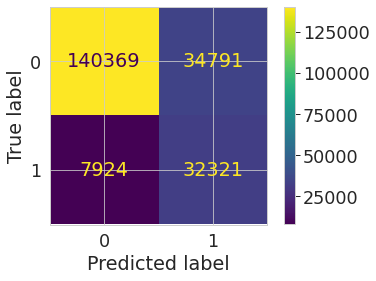

In [100]:
ConfusionMatrixDisplay.from_estimator(model_1, df_X_eval, y_eval)  
plt.show()

#### 2. **Gradient Boosting Classifier Model**

In [101]:
model_2 = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=0)
model_2.fit(df_X_train_re, y_train_re)

GradientBoostingClassifier(max_depth=1, random_state=0)

In [102]:
pred_2 = model_2.predict(df_X_eval)

In [103]:
# Calculate and print all four major metrics
print(f"Precision Score: {precision_score(y_eval, pred_2)}")
print(f"Recall Score: {recall_score(y_eval, pred_2)}")
print(f"Accuracy Score: {accuracy_score(y_eval, pred_2)}")
print(f"F1 Score: {f1_score(y_eval, pred_2)}")

Precision Score: 0.4905547567867667
Recall Score: 0.8562554354578209
Accuracy Score: 0.8070054084167034
F1 Score: 0.623755566013829


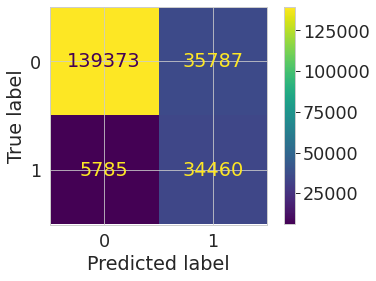

In [104]:
ConfusionMatrixDisplay.from_estimator(model_2, df_X_eval, y_eval)  
plt.show()

#### 3. **Logistic Regression Model**

In [105]:
model_3 = LogisticRegression(random_state = 0)
model_3.fit(df_X_train_re, y_train_re)

LogisticRegression(random_state=0)

In [106]:
pred_3 = model_3.predict(df_X_eval)

In [107]:
# Calculate and print all four major metrics
print(f"Precision Score: {precision_score(y_eval, pred_3)}")
print(f"Recall Score: {recall_score(y_eval, pred_3)}")
print(f"Accuracy Score: {accuracy_score(y_eval, pred_3)}")
print(f"F1 Score: {f1_score(y_eval, pred_3)}")

Precision Score: 0.4494030876929808
Recall Score: 0.8932786681575351
Accuracy Score: 0.7755855249413894
F1 Score: 0.5979707252162342


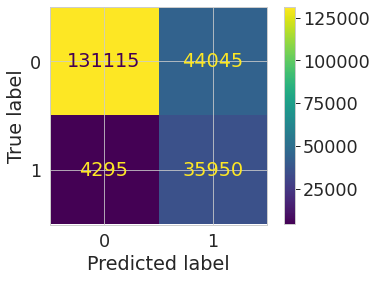

In [108]:
ConfusionMatrixDisplay.from_estimator(model_3, df_X_eval, y_eval)  
plt.show()

#### **4. Stochastic Gradient Descent**

In [109]:
model_4 = SGDClassifier(loss = 'modified_huber', shuffle = True, random_state = 0)
model_4.fit(df_X_train_re, y_train_re)

SGDClassifier(loss='modified_huber', random_state=0)

In [110]:
pred_4 = model_4.predict(df_X_eval)

In [111]:
# Calculate and print all four major metrics
print(f"Precision Score: {precision_score(y_eval, pred_4)}")
print(f"Recall Score: {recall_score(y_eval, pred_4)}")
print(f"Accuracy Score: {accuracy_score(y_eval, pred_4)}")
print(f"F1 Score: {f1_score(y_eval, pred_4)}")

Precision Score: 0.4480175497638011
Recall Score: 0.893129581314449
Accuracy Score: 0.7744434901696804
F1 Score: 0.596709663495858


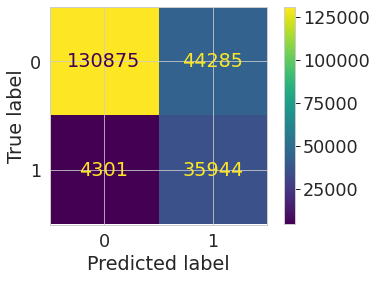

In [112]:
ConfusionMatrixDisplay.from_estimator(model_4, df_X_eval, y_eval)  
plt.show()

#### **5. Random Forest Classifier Model**

In [113]:
model_5 = RandomForestClassifier()
model_5.fit(df_X_train_re, y_train_re)

RandomForestClassifier()

In [114]:
pred_5 = model_5.predict(df_X_eval)

In [115]:
# Calculate and print all four major metrics
print(f"Precision Score: {precision_score(y_eval, pred_5)}")
print(f"Recall Score: {recall_score(y_eval, pred_5)}")
print(f"Accuracy Score: {accuracy_score(y_eval, pred_5)}")
print(f"F1 Score: {f1_score(y_eval, pred_5)}")

Precision Score: 0.5190346702923182
Recall Score: 0.7967946328736489
Accuracy Score: 0.824084863396857
F1 Score: 0.6285983122114734


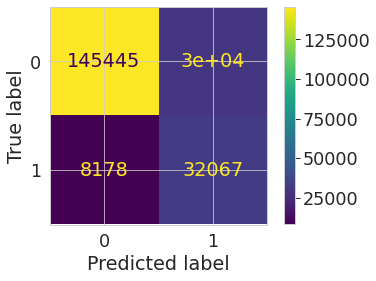

In [116]:
# Create and print a confusion matrix 
ConfusionMatrixDisplay.from_estimator(model_5, df_X_eval, y_eval)  
plt.show()

#### **6. Ada Boost Classifier Model**

In [117]:
model_6 = AdaBoostClassifier(random_state= 0)
model_6.fit(df_X_train_re, y_train_re)

AdaBoostClassifier(random_state=0)

In [118]:
pred_6 = model_6.predict(df_X_eval)

In [119]:
# Calculate and print all four major metrics
print(f"Precision Score: {precision_score(y_eval, pred_6)}")
print(f"Recall Score: {recall_score(y_eval, pred_6)}")
print(f"Accuracy Score: {accuracy_score(y_eval, pred_6)}")
print(f"F1 Score: {f1_score(y_eval, pred_6)}")

Precision Score: 0.5063335252583412
Recall Score: 0.8303391725680209
Accuracy Score: 0.8170469580557554
F1 Score: 0.6290673267885885


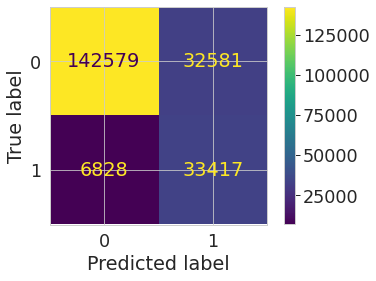

In [120]:
# Create and print a confusion matrix 
ConfusionMatrixDisplay.from_estimator(model_6, df_X_eval, y_eval)  
plt.show()

### **Model Selection**

In [121]:
print(f"F1 Score for Model 1: {f1_score(y_eval, pred_1)}")
print(f"F1 Score for Model 2: {f1_score(y_eval, pred_2)}")
print(f"F1 Score for Model 3: {f1_score(y_eval, pred_3)}")
print(f"F1 Score for Model 4: {f1_score(y_eval, pred_4)}")
print(f"F1 Score for Model 5: {f1_score(y_eval, pred_5)}")
print(f"F1 Score for Model 6: {f1_score(y_eval, pred_6)}")

F1 Score for Model 1: 0.6021218923777677
F1 Score for Model 2: 0.623755566013829
F1 Score for Model 3: 0.5979707252162342
F1 Score for Model 4: 0.596709663495858
F1 Score for Model 5: 0.6285983122114734
F1 Score for Model 6: 0.6290673267885885


**Comments:**

From the F1 scores above, we can see that **Model 6 and model 5** had the highest scores. So we will Select these two and do Hyperparameter tunning and retrain them with the best parameters for best performance.

#### **Hyperparameter tuning(GridSearchCV) - Ada Boost Classifier**

In [122]:
#Creating a grid of hyperparameters
grid_params = {'n_estimators': [100,200,300, 400]}
#Building a 3 fold CV GridSearchCV object
grid_object = GridSearchCV(estimator = AdaBoostClassifier(), param_grid = grid_params, scoring = 'roc_auc', cv = 3, n_jobs = -1)
# Concating train and test data into one dataset for our gridsearch
frame1 = [df_X_train, df_X_eval]
frame2 = [y_train, y_eval]
X_r= pd.concat(frame1)
y_r= pd.concat(frame2)
#Fitting the grid to the training data
grid_object.fit(X_r, y_r)

GridSearchCV(cv=3, estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid={'n_estimators': [100, 200, 300, 400]},
             scoring='roc_auc')

In [123]:
#Extracting the best parameters
grid_object.best_params_

{'n_estimators': 400}

In [124]:
# summarize the best score and configuration
print("Best: %f using %s" % (grid_object.best_score_, grid_object.best_params_))

Best: 0.899335 using {'n_estimators': 400}


#### **Applying best Parameters to Model 6 (Ada Boost Classifier)**

In [125]:
final_model = AdaBoostClassifier(n_estimators=300, random_state=0)

In [126]:
# end 2 end pipeline
pipe = Pipeline(
    steps=[("preprocessor", preprocessor), ("estimator", final_model)]
)

In [127]:
pipe.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc8ac1bc820>),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(categories=[array(['K > 24 month', 'E 6-9 month', 'H 15-18 month', 'G 12-15 month',
       'I 18-21 month', 'J 21-24 month', 'F 9-12 month', 'D 3-6 month'],
      dtype=object)],
                                                                                 drop='first',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc86a2ea250>)])),
                ('estimator',
                 AdaBoostClassifier(n_estimators=300, random_state=0))])

#### **Hyperparameter tuning(RandomSearchCV) - Random Forest Classifier**

In [128]:
n_estimators = [5,20,50,100] # number of trees in the random forest
max_features = ['auto', 'log2'] # number of features in consideration at every split
max_depth = range(2,20) # maximum number of levels allowed in each decision tree
min_samples_split = range(2,20) # minimum sample number to split a node
min_samples_leaf = range(1,10) # minimum sample number that can be stored in a leaf node
criteron = ['gini','entropy'] # method used to sample data points

random_grid = {'n_estimators': n_estimators,

'max_features': max_features,

'max_depth': max_depth,

'min_samples_split': min_samples_split,

'min_samples_leaf': min_samples_leaf,

'criterion': criteron}

In [129]:
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf,param_distributions = random_grid,
               n_iter = 10, cv = 5, verbose=2, random_state=35, n_jobs = -1)

In [64]:
rf_random.fit(X_r, y_r)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': range(2, 20),
                                        'max_features': ['auto', 'log2'],
                                        'min_samples_leaf': range(1, 10),
                                        'min_samples_split': range(2, 20),
                                        'n_estimators': [5, 20, 50, 100]},
                   random_state=35, verbose=2)

In [65]:
# Getting the Best Hyperparameters and scores
print(rf_random.best_params_)
print(rf_random.best_score_)

{'n_estimators': 100, 'min_samples_split': 7, 'min_samples_leaf': 9, 'max_features': 'log2', 'max_depth': 16, 'criterion': 'gini'}
0.8648535216997282


#### **Applying best Parameters to Model 5 (Random Forest Classifier)**

In [131]:
final_model2 = RandomForestClassifier(n_estimators= 100, min_samples_split= 7, min_samples_leaf= 9, max_features='log2', max_depth= 16, criterion= 'gini')

In [132]:
# end 2 end pipeline
pipe2 = Pipeline(
    steps=[("preprocessor", preprocessor), ("estimator", final_model2)]
)

In [133]:
pipe2.fit(X,y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc8ac1bc820>),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(categories=[array(['K > 24 month', 'E 6-9 month', 'H 15-18 month', 'G 12-15 month',
       'I 18-21 month', 'J 21-24 month', 'F 9-12 month', 'D 3-6 month'],
      dtype=object)],
                                                                                 drop='first',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc86a2ea250>)])),
                ('estimator',
                 RandomForestClassifier(max_depth=16, max_features='log2',
                                        min_samples_leaf=9,
                                        min_samples_split=7))])

#### **Feature Importance**

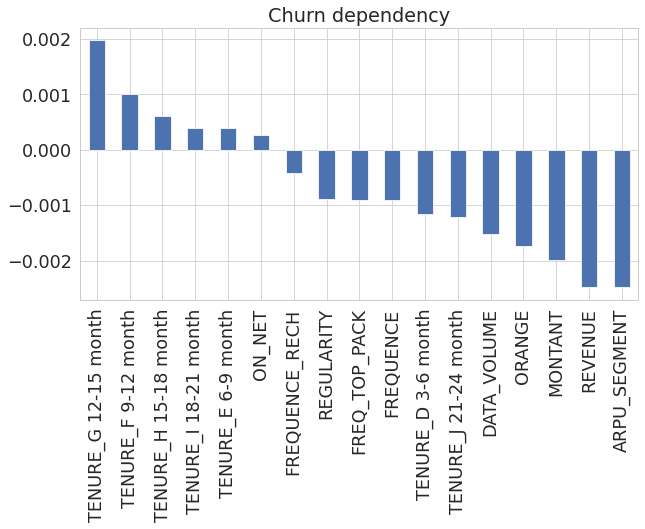

In [142]:
# Concatenate splitted data into a full dataset
full_df = pd.concat([df_X_train, y_train], axis=1)

correlation = full_df.corr()['CHURN'].sort_values(ascending=False)

# Correlation graph
correlation[1:].plot(kind='bar', figsize=(10,5), title='Churn dependency')
plt.show()

#### **Making test prediction & Preparing Submission file**

In [134]:
subpred = pipe2.predict(X_test_)

In [135]:
submission["CHURN"] = subpred

In [136]:
submission.head()

,user_id,CHURN
0,51fe4c3347db1f8571d18ac03f716c41acee30a4,0
1,5ad5d67c175bce107cc97b98c4e37dcc38aa7f3e,1
2,5a4db591c953a8d8f373877fad37aaf4268899a1,0
3,8bf9b4d8880aeba1c9a0da48be78f12e629be37c,0
4,c7cdf2af01e9fa95bf498b68c122aa4b9a8d10df,0


In [138]:
submission.to_csv('submission_5.csv', index=False)

## **Exportation**

In [139]:
# Objects tto export
to_export = {
    "pipeline": pipe,
    'numeric_columns': num_cols,
    'categorical_columns': cat_cols,
    'encoder_categories': encoder_categories}

In [140]:
# Exportation
with open('ML_items', 'wb') as file:
    pickle.dump(to_export, file)

In [141]:
# Loading after Exportation
with open('ML_items', 'rb') as file:
    loaded_object = pickle.load(file)